# RNN Testing

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

sys.path.append('../scripts')
import ml_helper as mlh
import ml_evaluation
import rnn
from rnn import RNN
import Baseline_classifiers as bc


In [3]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    # else "mps"
    # if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [4]:
organism = "E.Coli"
batch_size = 1
min_length = None
max_length = 600
padding_pos = "right" if batch_size > 1 else None

test_dataset = mlh.CodonDataset(organism=organism, split="test", min_length=min_length, max_length=max_length, padding_pos=padding_pos)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)
print("Länge test_dataset:", len(test_dataset))

Länge test_dataset: 712


In [5]:
# load newest model
rnnModel = mlh.load_model("rnn", organism)

Model loaded: 20240519144605_rnn.pt


In [6]:
predicted,labels, accuracy = rnn.evaluate(rnnModel, test_loader, device=device)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 51.82%


In [7]:
predicted_codon_names =  ml_evaluation.codon_to_name(predicted)
labels_codon_names =  ml_evaluation.codon_to_name(labels)

predicted_aa =  ml_evaluation.translate_codons(predicted_codon_names)
labels_aa =  ml_evaluation.translate_codons(labels_codon_names)

ml_evaluation.get_unique_pred_classes(predicted_codon_names, labels_codon_names)
ml_evaluation.print_unique_elements(predicted_aa, labels_aa)

accuracy_aa = accuracy_score(labels_aa, predicted_aa)
print(f'Accuracy of amino acids: {accuracy_aa*100:.2f}%')

predicted different classes:  48 out of: 64
predicted following classes:  {'CAG', 'CGC', 'TGC', 'AAA', 'GCC', 'ATG', 'TAT', 'GTC', 'AAT', 'TCT', 'CTG', 'GTA', 'GAT', 'CTC', 'GAA', 'TGG', 'GCG', 'TCA', 'ACA', 'TAA', 'TGT', 'TCC', 'CCA', 'CAT', 'AAC', 'ATT', 'CAA', 'TGA', 'AGT', 'GTG', 'GGG', 'ACG', 'GGC', 'TTA', 'ATC', 'ACC', 'GGT', 'CCG', 'GTT', 'CAC', 'TCG', 'TTC', 'CGT', 'AGC', 'GAC', 'TAC', 'TTT', 'GGA'}
predicted different amino acids:  21 out of: 21
Accuracy of amino acids: 100.00%


## Plots

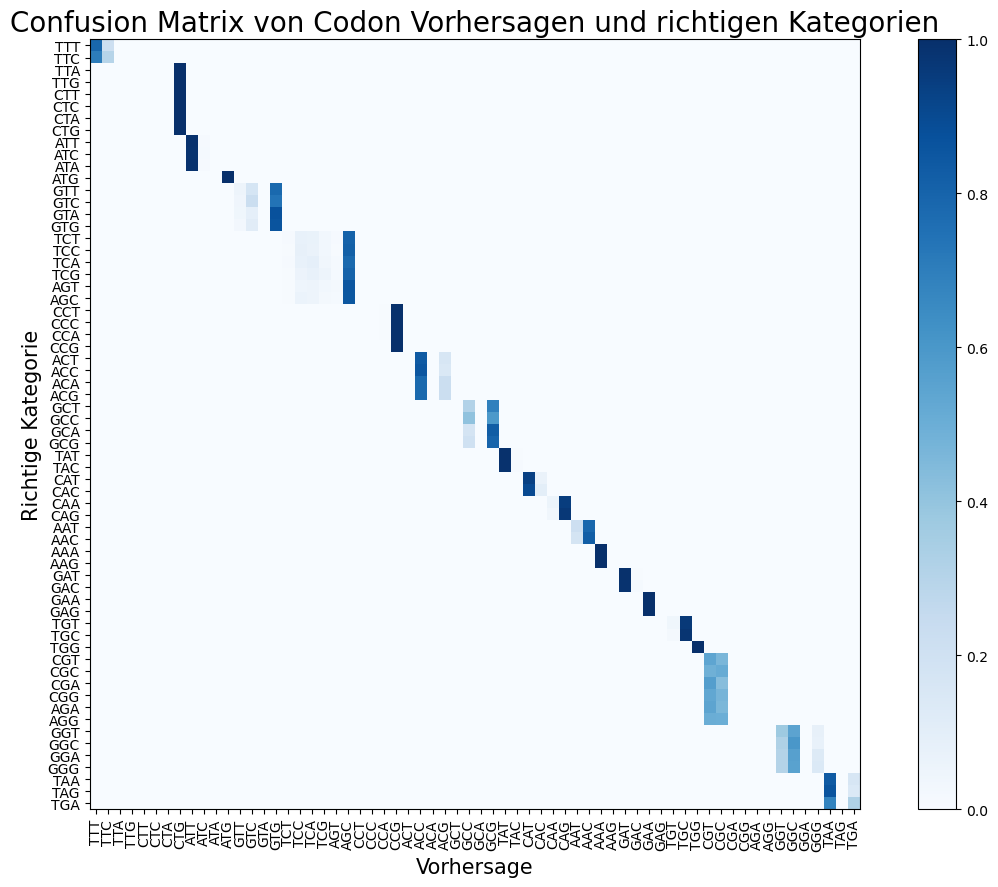

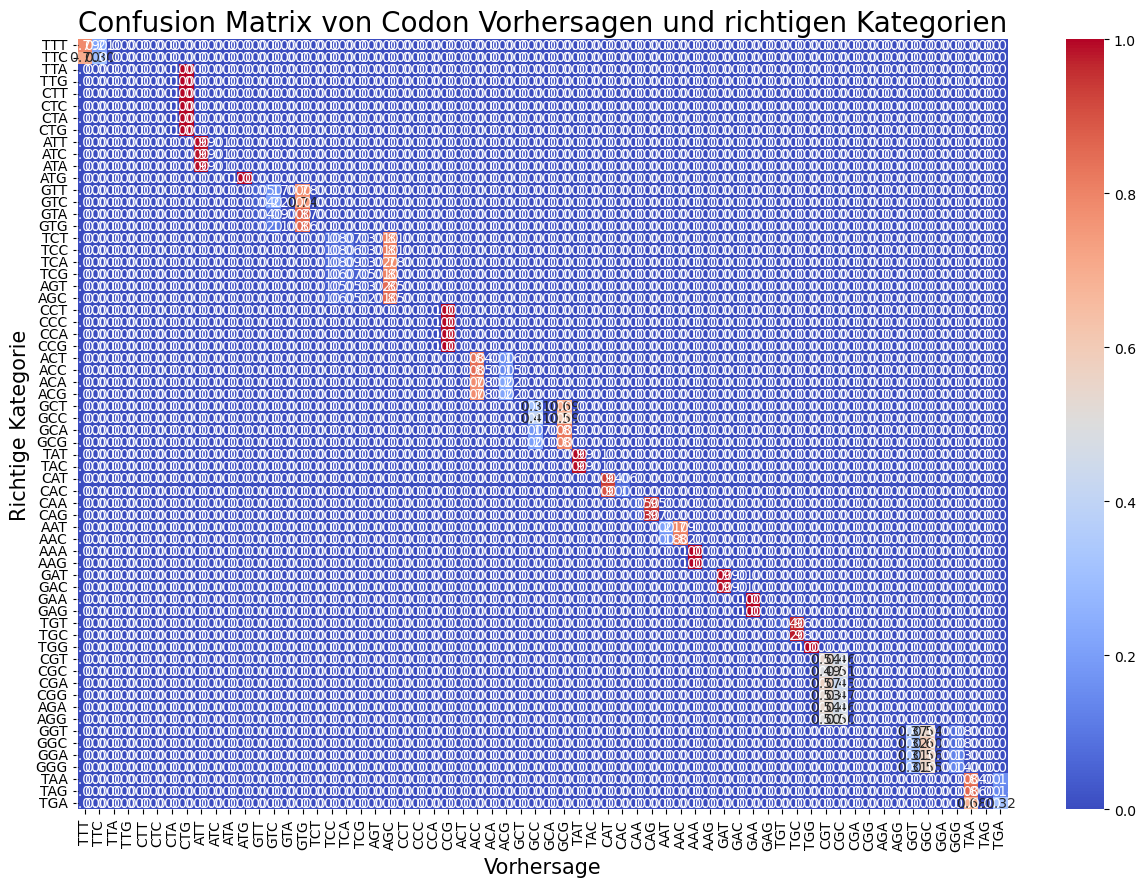

In [8]:
title = 'Confusion Matrix von Codon Vorhersagen und richtigen Kategorien'

codons = [c for c in mlh.codons if c != '___']

plt = ml_evaluation.plot_confusion_matrix(labels, predicted, mlh.codons_sorted, title, sort_codons=True)
plt.show()
plt = ml_evaluation.plot_confusion_matrix_sns(labels, predicted, mlh.codons_sorted, title, sort_codons=True)
plt.show()

### Aminosäuren Accuracy

$$A\_Acc = \frac{T\_a}{G\_a} $$

- $T\_a$: Anzahl der richtig klassifizierten ausgewählten Aminosäure über alle Testsequenzen eines betrachteten Organismus
- $G\_a$: Gesamtanzahl der ausgewählten Aminosäure über alle Testsequenzen eines betrachteten Organismus

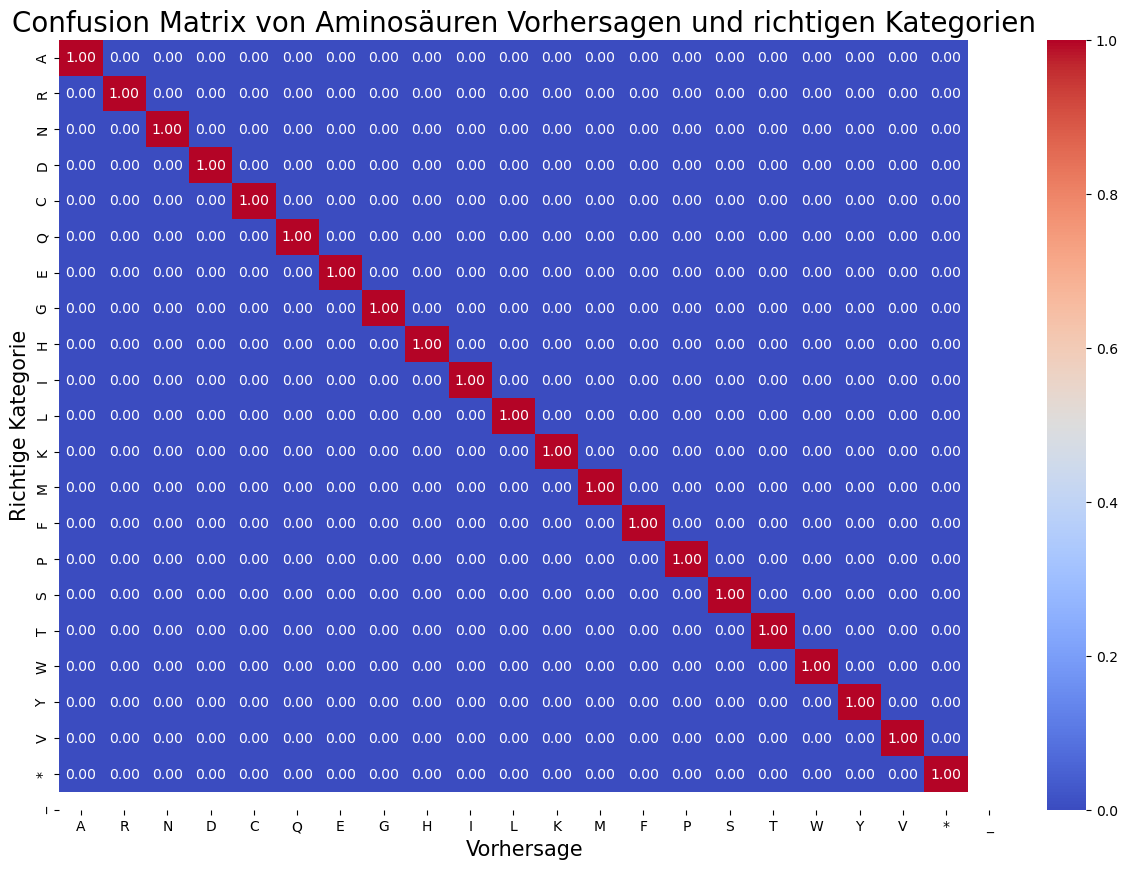

In [9]:
# Calculate confusion matrix for amino acids

plt = ml_evaluation.plot_confusion_matrix_sns(labels_aa, predicted_aa, mlh.amino_acids, 
                                        'Confusion Matrix von Aminosäuren Vorhersagen und richtigen Kategorien')
plt.show()

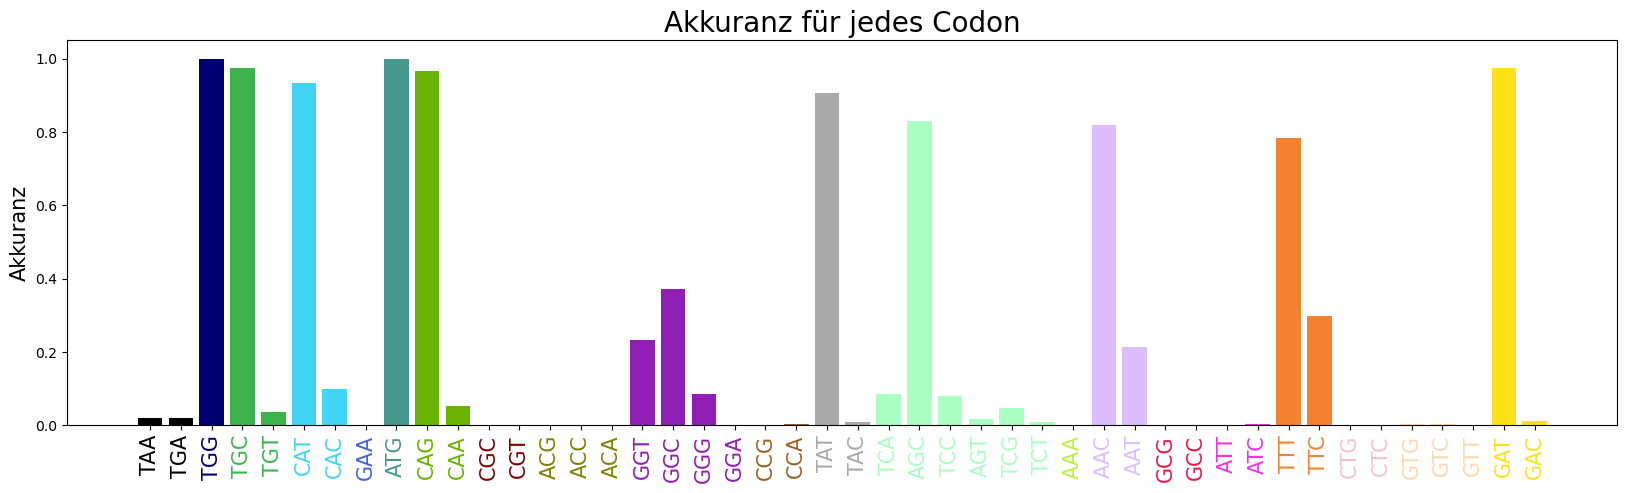

In [10]:
plt = ml_evaluation.plot_codon_acc(labels, predicted, 'Akkuranz für jedes Codon')

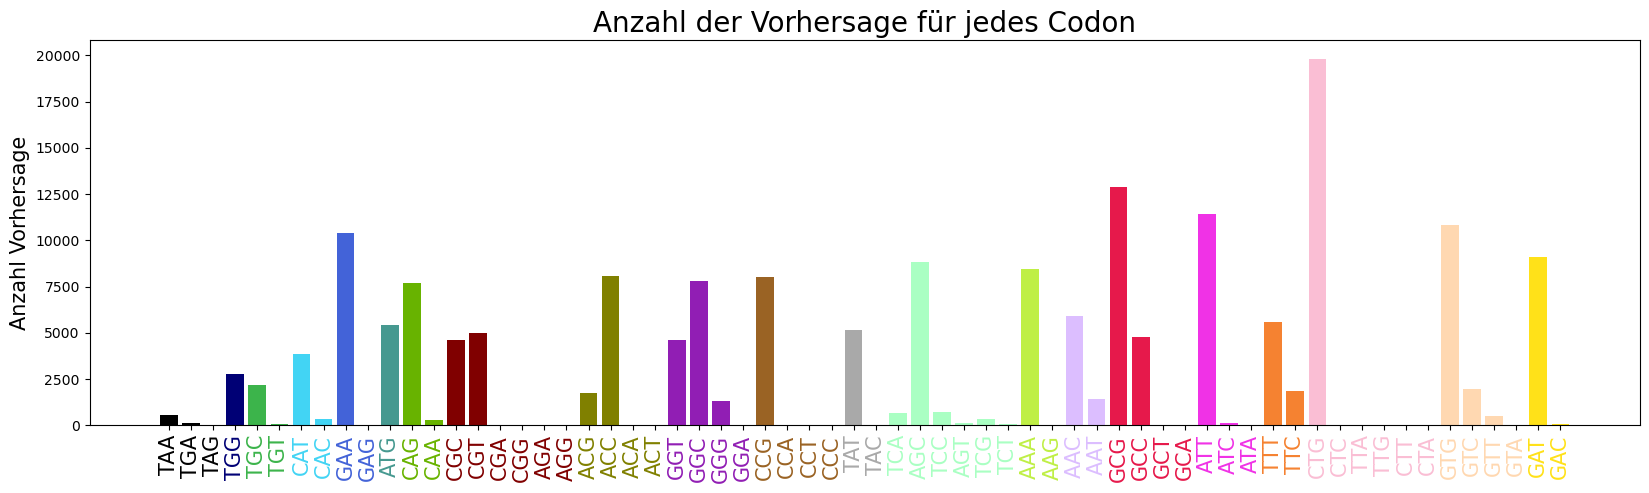

In [11]:
codon_counted_predicted = ml_evaluation.codon_count(predicted)

plt = ml_evaluation.plot_codon_count(codon_counted_predicted, 'Anzahl der Vorhersage für jedes Codon')

### Durchschnittliche Codon Accuracy

$$Avg\_CACC = \frac{\sum_{sc \in SC} c\_acc\{sc\}}{|SC|} $$

- $c\_acc$: Codon Accuracy
- $SC$: Synonyme Codons für die ausgewählte Aminosäure über alle Testsequenzen eines betrachteten Organismus

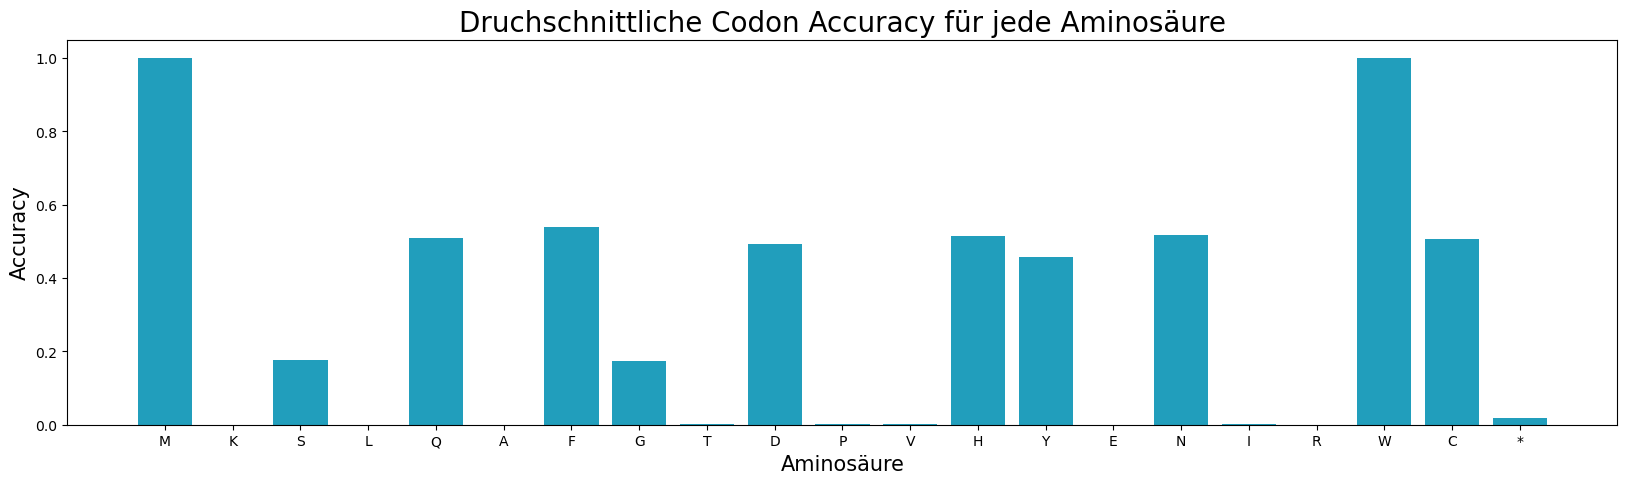

In [12]:
ml_evaluation.plot_avg_aa_acc(labels, predicted).show()

### Vergleich mit MCU

In [13]:
usage_biases = pd.read_pickle(f"../data/{organism}/usageBias.pkl")
